In [1]:

import cv2
import pytesseract
import matplotlib.pyplot as plt

In [2]:
placa = []
image = cv2.imread("C:/Users/DELL/Desktop/Octavo ciclo/Inteligencia Artificial/auto.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


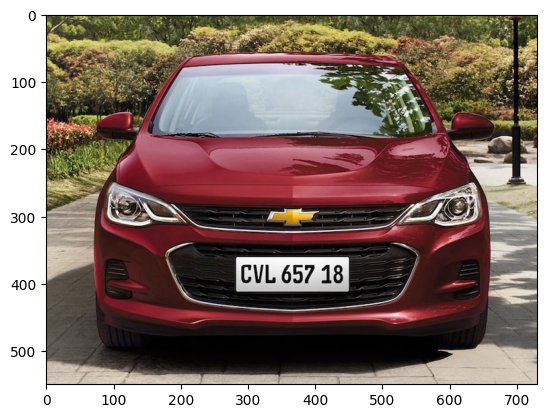

In [3]:

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

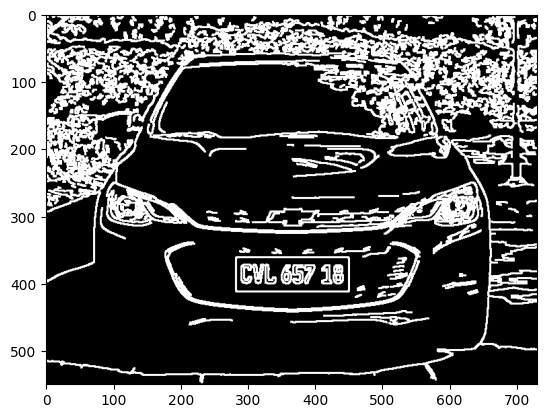

In [4]:
gray = cv2.blur(gray, (3,3))
canny = cv2.Canny(gray, 130, 200)
canny = cv2.dilate(canny, None, iterations=1)
plt.imshow(canny, cmap='gray');

In [7]:
import re

contorno, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for c in contorno:
    area = cv2.contourArea(c)
    x_pos, y_pos, width, height = cv2.boundingRect(c)
    epsilon = 0.09*cv2.arcLength(c, True) 
    approx = cv2.approxPolyDP(c, epsilon, True) 

    if(len(approx) == 4 and area > 9000): 
        aspect_ratio = float(width)/height
        print(f"area: {area}, x: {x_pos}, y: {y_pos}, width: {width}, height: {height}, aspect_ratio: {aspect_ratio}")
        
        cv2.drawContours(image, [approx], 0, (0, 255, 0), 3) 

        if(3 < aspect_ratio < 3.2): 
            placa = gray[y_pos:y_pos+height, x_pos:x_pos+width]
            
            text = pytesseract.image_to_string(placa, config='--psm 11'.strip())
            
            print(f"Placa: {text}")
            cv2.rectangle(image, (x_pos, y_pos), (x_pos+width, y_pos+height), (0, 255, 0), 3)
            text = re.sub(r'[^A-Za-z0-9 ]', '', text)  
            cv2.putText(image, text, (x_pos-20, y_pos-10), 1, 2.2, (0, 255, 0), 3)

area: 9007.0, x: 281, y: 360, width: 171, height: 54, aspect_ratio: 3.1666666666666665


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

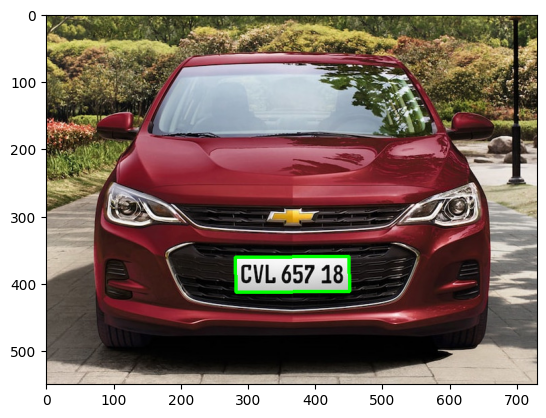

In [8]:

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [9]:

import cv2
import pytesseract
import matplotlib.pyplot as plt
import os

In [10]:

def get_canny_edges(
    gray: cv2.Mat, blur_params=(5, 5), canny_params=(100, 200), canny_dilate=1
) -> cv2.Mat:
    
    gray = cv2.GaussianBlur(gray, blur_params, 0)
    edges = cv2.Canny(gray, canny_params[0], canny_params[1])
    edges = cv2.dilate(edges, None, iterations=canny_dilate)
    return edges

In [11]:
def extract_text_by_aspect_ratio(
    image: cv2.Mat, edges: cv2.Mat, gray: cv2.Mat
) -> list[str]:

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    texts = []

    for contour in contours:
        area = cv2.contourArea(contour)
        x_pos, y_pos, width, height = cv2.boundingRect(contour)

        if area < 800 or width < 50 or height < 15:
            continue

        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) < 4 or len(approx) > 6:
            continue

        aspect_ratio = float(width) / height
        if not (1.5 <= aspect_ratio <= 5.0):  
            continue

        placa = gray[y_pos : y_pos + height, x_pos : x_pos + width]
        text = pytesseract.image_to_string(placa, config="--psm 8").strip()

    
        if len(text) < 4 or not any(char.isdigit() for char in text):
            continue
        
        cv2.rectangle(
            image, (x_pos, y_pos), (x_pos + width, y_pos + height), (0, 255, 0), 2
        )
        cv2.putText(
            image,
            text,
            (x_pos, y_pos - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 255, 0),
            2,
        )

        texts.append(text)

    return texts, image



In [12]:
def extract_text(edges, img, gray):
    return extract_text_by_aspect_ratio(img, edges, gray)

In [13]:
def get_slab_text(image_path: str, attempt=0, gray=None) -> tuple[list[str], cv2.Mat]:
    attempts = [
        ((5, 5), (100, 200)),
        ((7, 7), (50, 150)),
        ((3, 3), (120, 250)),
        ((9, 9), (30, 100)),
        ((1, 1), (200, 300)),
        ((11, 11), (20, 80)),
        ((5, 5), (75, 150)),
        ((7, 7), (100, 200)),
        ((3, 3), (50, 100)),
    ]

    if attempt >= len(attempts):
        return [], None

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return [], None

    if gray is None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur_params, canny_params = attempts[attempt]

    edges = get_canny_edges(gray, blur_params, canny_params)
    texts, updated_img = extract_text(edges, img, gray)

    if texts:
        return texts, updated_img

    return get_slab_text(image_path, attempt + 1, gray)

In [14]:


def get_all_files_in_directory(directory_path: str) -> list:
 
    if not os.path.exists(directory_path):
        print(f"Error: El directorio {directory_path} no existe.")
        return []

    return [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith(".png") or file.lower().endswith(".jpg")
    ]